## Example of using phase plates in TEM 

Sample: [Covid spike protein](https://www.rcsb.org/structure/3JCL)

09 May 2023 

Stephanie Ribet


In [23]:
import numpy as np
import abtem
from ase.io import read
from ase import Atoms

import matplotlib.pyplot as plt

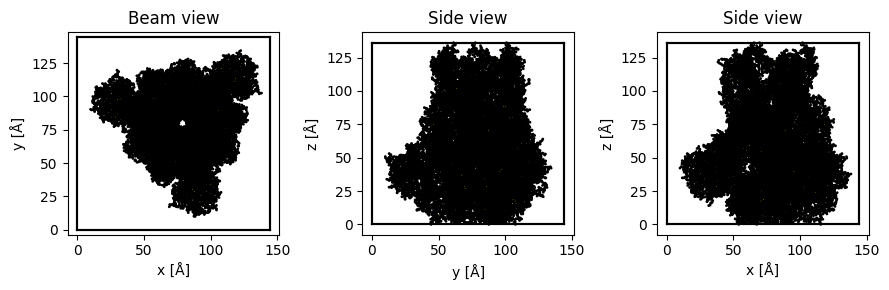

In [24]:
#load protein
atoms = read('data/3jcl.xyz')
atoms.positions[:,0] -= atoms.positions[:,0].min()
atoms.positions[:,1] -= atoms.positions[:,1].min()
atoms.positions[:,2] -= atoms.positions[:,2].min()

atoms.cell[0][0] = atoms.positions[:,0].max()
atoms.cell[1][1] = atoms.positions[:,1].max()
atoms.cell[2][2] = atoms.positions[:,2].max()

atoms.center(vacuum = 10, axis = (0,1))
atoms.cell[0][0] = atoms.cell[1][1]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))

abtem.show_atoms(atoms, ax=ax1, title="Beam view")
abtem.show_atoms(atoms, ax=ax2, plane="yz", title="Side view")
abtem.show_atoms(atoms, ax=ax3, plane="xz", title="Side view")

fig.tight_layout();

[########################################] | 100% Completed | 2.88 ss


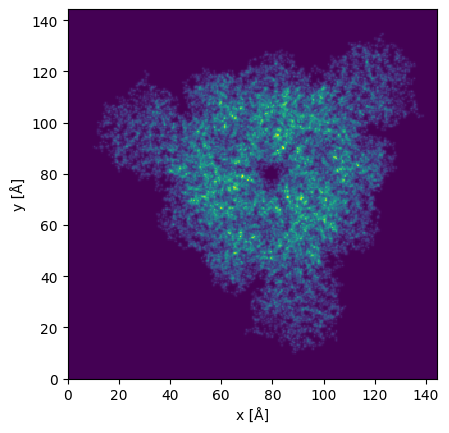

In [25]:
#make potential
potential = abtem.Potential(
    atoms, 
    sampling = 0.5,
)
potential.project().show();

In [26]:
#calcualte exit waves
wave = abtem.waves.PlaneWave(energy=300e3)
exit_waves = wave.multislice(potential).compute()

[########################################] | 100% Completed | 4.16 ss


In [27]:
#CTFs for in focus and defocus
ctf_defocused = abtem.CTF(
    aberration_coefficients={'C10': -10000}, 
    semiangle_cutoff = 10,
    energy=300e3)

ctf_infocus = abtem.CTF(
    aberration_coefficients={'C10': 0}, 
    semiangle_cutoff = 10,
    energy=300e3)
dose = 100

In [28]:
#calcualte in focus and defocus images
image_defocus = exit_waves.apply_ctf(ctf_defocused)
image_infocus = exit_waves.apply_ctf(ctf_infocus)

intensity_defocus = image_defocus.intensity()
intensity_infocus = image_infocus.intensity()

noisy_defocus = intensity_defocus.poisson_noise(dose)
noisy_infocus = intensity_defocus.poisson_noise(dose)

(<Figure size 800x300 with 2 Axes>, <Axes: xlabel='x [Å]', ylabel='y [Å]'>)

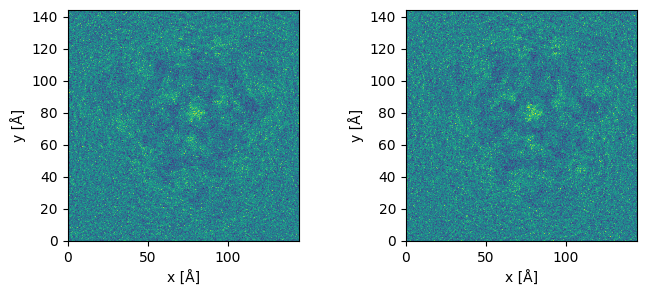

In [29]:
#The defocused probe provides better transer of information
plot_range = [55, 1]

fig, ax = plt.subplots(1,2, figsize = (8,3))
noisy_defocus.show(ax= ax[0], vmax = plot_range[0], vmin = plot_range[1])
noisy_infocus.show(ax= ax[1], vmax = plot_range[0], vmin = plot_range[1])

In [30]:
#create zernike probe
class Diverse_CTF(abtem.transfer.CTF):
    """
    child class of abTEM contrast transfer function
    """
    def __init__(
        self, 
        energy,
        defocus, 
        cutoff = 10/1000, 
        *args, 
        **kwargs):
        """
        Parameters
        ----------
       
        """
         
        self.cutoff = cutoff
        self.E0 = energy
        
        super().__init__(
            energy = energy,
            defocus = defocus,
            *args, 
            **kwargs)
        
    def evaluate(self, 
                 alpha, 
                 phi):
        """
        Parameters
        ----------

        Returns
        -------
        CTF: Union[float, np.ndarray]
            custom contrast transfer function 
        """
        from abtem.device import get_array_module, get_device_function

        xp = get_array_module(alpha)
        
        CTF = self.evaluate_aperture(alpha,phi)*self.evaluate_aberrations(alpha, phi)

        zernike = np.zeros_like(alpha) 
        zernike[alpha > self.cutoff] =np.pi/2
        CTF *= xp.exp(1j * zernike)            
            
        return CTF

In [31]:
zernike_ctf = Diverse_CTF(
    300e3, 
    defocus = 0,
    cutoff=1/1000, 
    semiangle_cutoff = 10,
)

In [32]:
#plot complex CTF
#zernike_ctf.complex_images(exit_waves.grid).show(cbar = True)

In [33]:
image_wave_zernike = exit_waves.apply_ctf(zernike_ctf)

intensity_zernike = image_wave_zernike.intensity()

noisy_zernike = poisson_noise(intensity_zernike, dose)


TypeError: evaluate() missing 1 required positional argument: 'phi'

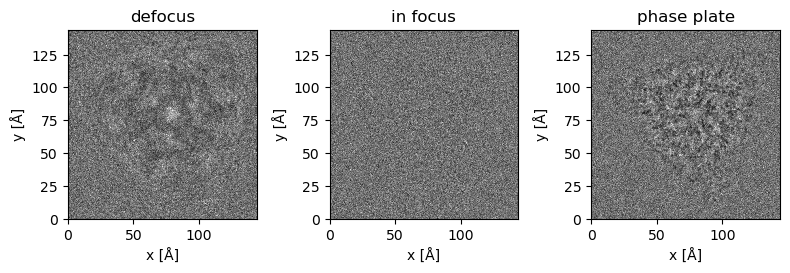

In [12]:
#zernike provides best transfer of information
plot_range = [55, 1]

fig, ax = plt.subplots(1,3, figsize = (8,3))
noisy_defocus.show(ax = ax[0], vmax = plot_range[0], vmin = plot_range[1])
noisy_infocus.show(ax = ax[1], vmax = plot_range[0], vmin = plot_range[1])
noisy_zernike.show(ax = ax[2], vmax = plot_range[0], vmin = plot_range[1])


ax[0].set_title('defocus')
ax[1].set_title('in focus')
ax[2].set_title('phase plate') 
plt.tight_layout()